In [1]:
import os
import uproot
import h5py
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

# Functions 

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(np.sum(e)**2 - np.sum(px)**2 - np.sum(py)**2 - np.sum(pz)**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [3]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest              

In [4]:
def display_cutflow_table(result):
    pd.set_option('display.precision', 4)
    nevent = result['nevent']
    cut_list = []
    for key in result:
        if key != 'Mass' and key != 'nevent' and key != 'Cross section':
            cut_list.append(key)

    pass_rate_list = []
    efficiency_list = []
    
    for i, cut in enumerate(cut_list):
        pass_rate_list.append(result[cut]/nevent)
        if i == 0:
            efficiency_list.append(pass_rate_list[i]/1)
        else:
            efficiency_list.append(pass_rate_list[i]/pass_rate_list[i-1])
    data = {'Cut': cut_list, 'pass rate': pass_rate_list, 'efficiency': efficiency_list}
    
    df = pd.DataFrame(data)
    
    display(df)
    
def print_sb_info(key, signal, background, L=[139]):
    nL = len(L)
    L = np.array(L)
    
    cross_section_s = signal[key] 
    cross_section_b = background[key] 
    nS = L * cross_section_s
    nB = L * cross_section_b
    
    content_format = '{:15} {:<12.3f} {:<12.3} {:<12.3}' + ' {:<12.4f}'* nL
    print(content_format.format(key, cross_section_s, cross_section_b, nS[0]/nB[0], *nS/nB**0.5))

def signal_background_table(signal, background, L=[139]):
    # unit of luminosity L is fb
    nL = len(L)
    L = np.array(L)

    row_format = '{:15} {:<12} {:<12} {:<12}' + ' {:<12}'* nL
    print(row_format.format('', '', '', '', *L))
    print(row_format.format('', 'Signal', 'Background', 'S/B', *['S/sqrt{B}'] * nL))
    
    cross_section_s = signal['Cross section']
    cross_section_b = background['Cross section']
    nS = L * cross_section_s
    nB = L * cross_section_b
    
    content_format = '{:15} {:<12.3f} {:<12.3} {:<12.3}' + ' {:<12.4f}'* nL
    print(content_format.format('No cut', cross_section_s, cross_section_b, nS[0]/nB[0], *nS/nB**0.5))
    
    for key in signal:
        if key != 'nevent' and key != 'Cross section':
            print_sb_info(key, signal, background, L)
            
def print_count_xsection(text, cross_section, count, total):
    print(text, count, cross_section * count / total)

## Selection

In [5]:
def deltaR_condition(R1, R2, m4j):
    # R1: Delta R of leading Higgs candidate
    # R2: Delta R of sub-leading Higgs candidate
    
    if m4j < 1250:
        if R1 > 653 / m4j + 0.475:
            return False
        if R1 < 360 / m4j - 0.5:
            return False

        if R2 > 875 / m4j + 0.35:
            return False
        if R2 < 235 / m4j:
            return False      
    else:
        if R1 > 1:
            return False
        if R1 < 0:
            return False

        if R2 > 1:
            return False
        if R2 < 0:
            return False
    return True
    

def DHH(m1, m2):
    # m1: mass of leading Higgs candidate
    # m2: mass of sub-leading Higgs candidate
    
    return abs(m1 - 120/110*m2) / (1 + (120/110)**2)**0.5
    
def pt_condition(pt1, pt2, m4j):
    # pt1: PT of leading Higgs candidate
    # pt2: PT of sub-leading Higgs candidate
    
    if pt1 < 0.5 * m4j - 103:
        return False
    if pt2 < 0.33 * m4j - 73:
        return False
    return True

def XHH(m1, m2, m10=120, m20=110):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return (((m1-m10)/(0.1*m1))**2 + ((m2-m20)/(0.1*m2))**2)**0.5

def XWt(mW, mt):
    # mW: W boson candidate mass
    # mt: top candidate mass
    
    return (((mW-80)/(0.1*mW))**2 + ((mt-173)/(0.1*mt))**2)**0.5

def DHH_dR_method(PT, Eta, Phi, Mass):
    # get the pairing by DeltaR method
    # 已經過 preseleciton PT, Eta, Phi, Mass都只有4個jets的資料
    
    # Total invariant mass of 4 b-jets
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
    
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
        PT1 = PT[[i1,i2]]
        PT2 = PT[[i3,i4]]
        # sorted by PT scalar sum
        if np.sum(PT1) < np.sum(PT2):
            i1, i2, i3, i4 = i3, i4, i1, i2

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]

        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

        if deltaR_condition(dR1, dR2, m4j):
            d = DHH(mH1, mH2)
            pairing.append([i1,i2,i3,i4, d])
    
    if len(pairing) == 0:
        return pairing
    
    # choose the pairing with minimum DHH
    h_candidate = pairing[0][0:4]
    min_DHH = pairing[0][4]
    for i1,i2,i3,i4, d in pairing:
        if d < min_DHH:
            min_DHH = d
            h_candidate = [i1,i2,i3,i4]

    return h_candidate
def top_veto(PT, Eta, Phi, M, h_jets, central_jets):
    # PT, Eta, Phi, M are jets 4-momentum
    # h_jets: the index of h jets candidate
    # central_jets: index of central jets
    
    XWt_flag = False
    for b in h_jets:
        PTb = PT[b]
        Etab = Eta[b]
        Phib = Phi[b]
        Massb = M[b]
        eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

        for i1,i2 in itertools.combinations(central_jets, 2):
            if b == i1 or b == i2:
                continue
            PTW = PT[[i1,i2]]
            EtaW = Eta[[i1,i2]]
            PhiW = Phi[[i1,i2]]
            MassW = M[[i1,i2]]

            eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
            mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

            et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
            mt = InvM(et, pxt, pyt, pzt)

            if XWt(mW, mt) < 1.5:
                XWt_flag = True
                return XWt_flag

    return XWt_flag

def min_dR_method(PT, Eta, Phi, Mass):
    # get h-jets pairing
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]
        
        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
        
        # sorted by PT vector sum
        if PTH1 < PTH2:
            i1, i2, i3, i4 = i3, i4, i1, i2
            PTH1, EtaH1, PhiH1, PTH2, EtaH2, PhiH2 = PTH2, EtaH2, PhiH2, PTH1, EtaH1, PhiH1

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        pairing.append([i1,i2,i3,i4, dR1])
    
    h_candidate = pairing[0][0:4]
    min_dR = pairing[0][4]
    for i1,i2,i3,i4, dR in pairing:
        if dR < min_dR:
            min_dR = dR
            h_candidate = [i1,i2,i3,i4]
            
    return h_candidate

def SPANet_pairing(PT, Eta, Phi, Mass):
    # 已經過 preseleciton PT, Eta, Phi, Mass只有4個jets的資料
    i1, i2, i3, i4 = 0,1,2,3
    
    PT1 = PT[[i1,i2]] 
    Eta1 = Eta[[i1,i2]]
    Phi1 = Phi[[i1,i2]]
    Mass1 = Mass[[i1,i2]]

    e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
    PTH1, _, _, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

    PT2 = PT[[i3,i4]]
    Eta2 = Eta[[i3,i4]]
    Phi2 = Phi[[i3,i4]]
    Mass2 = Mass[[i3,i4]]

    e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
    PTH2, _, _, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

    # sorted by PT vector sum
    if PTH1 > PTH2:
        return [0, 1, 2, 3]
    else:
        return [2, 3, 0, 1]  

# HDF5 process 

In [6]:
def diHiggs_selection(file_path, tot_event, pairing_method, xection=None, title='', nevent_max=1000):
    # 輸入檔案為 HDF5 檔
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XWt_count = 0
        XHH_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        mh = [[], []]
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'min_dR':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                h_candidate = min_dR_method(PT, Eta, Phi, Mass)
            elif pairing_method == 'SPANET':
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]         
                h_candidate = SPANet_pairing(PT, Eta, Phi, Mass)
            elif pairing_method == 'dR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]

                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                h_candidate = DHH_dR_method(PT, Eta, Phi, Mass)
                
                if len(h_candidate) == 0:
                    continue            
            else:
                print('Wrong pairing method')
            dR_count += 1
            
            # Total invariant mass: mhh
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
                    
            # Get Higgs candidates information
            i1, i2, i3, i4 = h_candidate[0:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
            
            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1         

            # |dEta_HH| < 1.5
            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1
            
            mh[0].append(MassH1)
            mh[1].append(MassH2)
            
            # Signal region
            if XHH(MassH1, MassH2) > 1.6:
                continue
            XHH_count += 1

            # Top veto
            XWt_flag = top_veto(jet_PT, jet_Eta, jet_Phi, jet_Mass, h_jets, eta_pt_cut)
            if XWt_flag:
                continue
            XWt_count += 1


        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

#         print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
#         print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent) 
#         print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
#         print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)

#         print_count_xsection('Signal region:', cross_section_abs, XHH_count, nevent)
#         print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
        
        
        cutflow_count = {
            'nevent': tot_event,
            'Cross section': cross_section,
            'Eta PT BTag cut': Eta_PT_BTag_count,
            'Delta R': dR_count,
            'Higgs PT cut': HPT_count,
            'Higgs Eta cut': HEta_count,
            'Higgs signal': XHH_count,
            'Top veto': XWt_count,
        }
         
        cutflow_cross_section = {
            'nevent': nevent,
            'Cross section': cross_section,
            'Eta PT BTag cut': cross_section_abs,
            'Delta R': cross_section_abs * dR_count / nevent,
            'Higgs PT cut': cross_section_abs * HPT_count / nevent,
            'Higgs Eta cut': cross_section_abs * HEta_count / nevent,    
            'Higgs signal': cross_section_abs * XHH_count / nevent,
            'Top veto': cross_section_abs * XWt_count / nevent, 
        }
        
        results = {
            'cutflow count': cutflow_count,
            'cutflow cross section':cutflow_cross_section,
            'mh': mh,
#             'mhh': mhh,
        }
        
        return results

In [7]:
def diHiggs_selection_new(file_path, tot_event, pairing_method, xection=None, title='', nevent_max=1000):
    # 輸入檔案為 HDF5 檔
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HEta_count = 0
        XWt_count = 0
        XHH_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        mh = [[], []]
        mhh = []
        
        for event in tqdm(range(nevent)):   
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1        
                      
            if pairing_method == 'min_dR':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets] 
                h_candidate = min_dR_method(PT, Eta, Phi, Mass)
            elif pairing_method == 'SPANET':
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]         
                h_candidate = SPANet_pairing(PT, Eta, Phi, Mass)
            else:
                print('Wrong pairing method')
            
            # Total invariant mass: mhh
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            # Get Higgs candidates information
            i1, i2, i3, i4 = h_candidate[0:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            # |dEta_HH| < 1.5
            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1

            # Top veto
            XWt_flag = top_veto(jet_PT, jet_Eta, jet_Phi, jet_Mass, h_jets, eta_pt_cut)
            if XWt_flag:
                continue
            XWt_count += 1
            
            mh[0].append(MassH1)
            mh[1].append(MassH2)

            # signal region
            if XHH(MassH1, MassH2, 124, 117) > 1.6:
                continue
            XHH_count += 1
            
            mhh.append(m4j)

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

#         print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
#         print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
#         print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
#         print_count_xsection('Signal region:', cross_section_abs, XHH_count, nevent)
        
        
        cutflow_count = {
            'nevent': tot_event,
            'Cross section': cross_section,
            'Four tag': Eta_PT_BTag_count,
            'Higgs Eta cut': HEta_count,
            'Top veto': XWt_count,
            'Higgs signal': XHH_count,
        }
         
        cutflow_cross_section = {
            'nevent': nevent,
            'Cross section': cross_section,
            'Four tag': cross_section_abs,
            'Higgs Eta cut': cross_section_abs * HEta_count / nevent,
            'Top veto': cross_section_abs * XWt_count / nevent, 
            'Higgs signal': cross_section_abs * XHH_count / nevent,        
        }
        
        results = {
            'cutflow count': cutflow_count,
            'cutflow cross section':cutflow_cross_section,
            'mh': mh,
            'mhh': mhh,
        }
        
        return results

# Selection

## Old selection
Pairing method: $\Delta R -\text{min-}D_{HH}$, $\text{min-}\Delta R$, SPA-NET

### Signal

In [8]:
# 13 TeV resonant 1000 GeV 
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
xection = 0.6442

In [9]:
pairing_method = 'dR_minDHH'
old_DHH_s = diHiggs_selection(file_path, 
                              tot_event,
                              pairing_method,
                              xection,
                              title='pp->hh', 
                              nevent_max=100000)

print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_DHH_s['cutflow count'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:37<00:00, 336.38it/s]


pp->hh
In 12573 events
Cross section: 0.6442 fb
Pairing method: dR_minDHH


,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.1257,0.1257
1,Delta R,0.1087,0.8644
2,Higgs PT cut,0.0896,0.8247
3,Higgs Eta cut,0.0826,0.9216
4,Higgs signal,0.0445,0.5391
5,Top veto,0.0425,0.9555


In [10]:
pairing_method = 'min_dR'
old_min_dR_s = diHiggs_selection(file_path, 
                              tot_event,
                              pairing_method,
                              xection,
                              title='pp->hh', 
                              nevent_max=100000)

print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_min_dR_s['cutflow count'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:35<00:00, 350.32it/s]

pp->hh
In 12573 events
Cross section: 0.6442 fb
Pairing method: min_dR


,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.1257,0.1257
1,Delta R,0.1257,1.0000
2,Higgs PT cut,0.0936,0.7444
3,Higgs Eta cut,0.0863,0.9226
4,Higgs signal,0.0445,0.5155
5,Top veto,0.0425,0.9553


In [11]:
pairing_method = 'SPANET'
old_SPANET_s = diHiggs_selection(file_path, 
                              tot_event,
                              pairing_method,
                              xection,
                              title='pp->hh', 
                              nevent_max=100000)

print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_SPANET_s['cutflow count'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:41<00:00, 300.40it/s]

pp->hh
In 12573 events
Cross section: 0.6442 fb
Pairing method: SPANET


,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.1257,0.1257
1,Delta R,0.1257,1.0000
2,Higgs PT cut,0.0978,0.7775
3,Higgs Eta cut,0.0900,0.9203
4,Higgs signal,0.0468,0.5197
5,Top veto,0.0446,0.9536


### Background

In [12]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
xection = 628589.0502929688

In [13]:
pairing_method = 'dR_minDHH'
old_DHH_4b = diHiggs_selection(file_path, 
                                    tot_event,
                                    pairing_method,
                                    xection,
                                    title='pp->4b', 
                                    nevent_max=10000)
print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_DHH_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:19<00:00, 499.00it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
Pairing method: dR_minDHH


,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.0096,0.0096
1,Delta R,0.0050,0.5234
2,Higgs PT cut,0.0043,0.8462
3,Higgs Eta cut,0.0030,0.7127
4,Higgs signal,0.0005,0.1551
5,Top veto,0.0003,0.5975


In [14]:
pairing_method = 'min_dR'
old_min_dR_4b = diHiggs_selection(file_path, 
                                    tot_event,
                                    pairing_method,
                                    xection,
                                    title='pp->4b', 
                                    nevent_max=10000)
print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_min_dR_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:18<00:00, 520.18it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
Pairing method: min_dR


,Cut,pass rate,efficiency
0,Eta PT BTag cut,9.6420e-03,0.0096
1,Delta R,9.6420e-03,1.0000
2,Higgs PT cut,6.6460e-03,0.6893
3,Higgs Eta cut,5.0040e-03,0.7529
4,Higgs signal,1.1600e-04,0.0232
5,Top veto,9.4000e-05,0.8103


In [15]:
pairing_method = 'SPANET'
old_SPANET_4b = diHiggs_selection(file_path, 
                                    tot_event,
                                    pairing_method,
                                    xection,
                                    title='pp->4b', 
                                    nevent_max=10000)
print(f'Pairing method: {pairing_method}')
display_cutflow_table(old_SPANET_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:22<00:00, 434.97it/s]


pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
Pairing method: SPANET


,Cut,pass rate,efficiency
0,Eta PT BTag cut,9.6420e-03,0.0096
1,Delta R,9.6420e-03,1.0000
2,Higgs PT cut,6.7200e-03,0.6970
3,Higgs Eta cut,4.8580e-03,0.7229
4,Higgs signal,7.5000e-05,0.0154
5,Top veto,6.6000e-05,0.8800


## New selection
Pairing method: $\text{min-}\Delta R$, SPA-NET

### Signal

In [16]:
# 13 TeV kappa=1
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_DL1r_PT40_non-resonant_predict.h5'
tot_event = 100000
xection = 20.251 * 0.582 * 0.582

In [17]:
pairing_method = 'min_dR'
min_s = diHiggs_selection_new(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)
display_cutflow_table(min_s['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8516/8516 [00:34<00:00, 248.08it/s]

pp->hh
In 8516 events
Cross section: 6.859499724 fb


,Cut,pass rate,efficiency
0,Four tag,0.0852,0.0852
1,Higgs Eta cut,0.0688,0.8074
2,Top veto,0.0553,0.8044
3,Higgs signal,0.0181,0.3282


In [18]:
pairing_method = 'SPANET'
SPANET_s = diHiggs_selection_new(file_path, 
                                    tot_event, 
                                    pairing_method,   
                                    xection,
                                    title='pp->hh', 
                                    nevent_max=10000)
display_cutflow_table(SPANET_s['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8516/8516 [00:37<00:00, 225.36it/s]

pp->hh
In 8516 events
Cross section: 6.859499724 fb


,Cut,pass rate,efficiency
0,Four tag,0.0852,0.0852
1,Higgs Eta cut,0.0676,0.7942
2,Top veto,0.0544,0.8051
3,Higgs signal,0.0194,0.3567


In [19]:
# SPANET is trained on 450 GeV resonant sample 
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_DL1r_PT40_non-resonant_resonant-predict.h5'
tot_event = 100000
xection = 20.251 * 0.582 * 0.582

In [20]:
pairing_method = 'SPANET'
res_SPANET_s = diHiggs_selection_new(file_path, 
                                        tot_event, 
                                        pairing_method,   
                                        xection,
                                        title='pp->hh', 
                                        nevent_max=10000)
display_cutflow_table(res_SPANET_s['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8516/8516 [00:37<00:00, 228.00it/s]

pp->hh
In 8516 events
Cross section: 6.859499724 fb


,Cut,pass rate,efficiency
0,Four tag,0.0852,0.0852
1,Higgs Eta cut,0.0685,0.8048
2,Top veto,0.0550,0.8022
3,Higgs signal,0.0181,0.3296


In [21]:
# SPANET is trained on kappa=5 sample 
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_DL1r_PT40_non-resonant_predict-k5.h5'
tot_event = 100000
xection = 20.251 * 0.582 * 0.582

In [22]:
pairing_method = 'SPANET'
k5_SPANET_s = diHiggs_selection_new(file_path, 
                                        tot_event, 
                                        pairing_method,   
                                        xection,
                                        title='pp->hh', 
                                        nevent_max=10000)
display_cutflow_table(k5_SPANET_s['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8516/8516 [00:37<00:00, 228.79it/s]

pp->hh
In 8516 events
Cross section: 6.859499724 fb


,Cut,pass rate,efficiency
0,Four tag,0.0852,0.0852
1,Higgs Eta cut,0.0677,0.7954
2,Top veto,0.0545,0.8043
3,Higgs signal,0.0196,0.3605


### Background 

In [23]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict.h5'
tot_event = 1000000
xection = 628589.0502929688

In [24]:
pairing_method = 'min_dR'
min_4b = diHiggs_selection_new(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=10000)
display_cutflow_table(min_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:28<00:00, 339.26it/s]


pp->4b
In 9642 events
Cross section: 628589.0502929688 fb


,Cut,pass rate,efficiency
0,Four tag,9.6420e-03,0.0096
1,Higgs Eta cut,5.6260e-03,0.5835
2,Top veto,4.1760e-03,0.7423
3,Higgs signal,9.7000e-05,0.0232


In [25]:
pairing_method = 'SPANET'
SPANET_4b = diHiggs_selection_new(file_path, 
                                    tot_event,
                                    pairing_method,
                                    xection,
                                    title='pp->4b', 
                                    nevent_max=10000)
display_cutflow_table(SPANET_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:30<00:00, 311.97it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb


,Cut,pass rate,efficiency
0,Four tag,0.0096,0.0096
1,Higgs Eta cut,0.0050,0.5202
2,Top veto,0.0037,0.7341
3,Higgs signal,0.0002,0.0443


In [26]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b-resonant_predict.h5'
tot_event = 1000000
xection = 628589.0502929688

In [27]:
pairing_method = 'SPANET'
res_SPANET_4b = diHiggs_selection_new(file_path, 
                                        tot_event,
                                        pairing_method,
                                        xection,
                                        title='pp->4b', 
                                        nevent_max=10000)
display_cutflow_table(res_SPANET_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:31<00:00, 304.50it/s]


pp->4b
In 9642 events
Cross section: 628589.0502929688 fb


,Cut,pass rate,efficiency
0,Four tag,9.6420e-03,0.0096
1,Higgs Eta cut,5.3890e-03,0.5589
2,Top veto,3.9480e-03,0.7326
3,Higgs signal,7.9000e-05,0.0200


In [28]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict-k5.h5'
tot_event = 1000000
xection = 628589.0502929688

In [29]:
pairing_method = 'SPANET'
k5_SPANET_4b = diHiggs_selection_new(file_path, 
                                        tot_event,
                                        pairing_method,
                                        xection,
                                        title='pp->4b', 
                                        nevent_max=10000)
display_cutflow_table(k5_SPANET_4b['cutflow count'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:31<00:00, 309.29it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb


,Cut,pass rate,efficiency
0,Four tag,0.0096,0.0096
1,Higgs Eta cut,0.0050,0.5210
2,Top veto,0.0037,0.7454
3,Higgs signal,0.0003,0.0881


# Results of S/B

In [30]:
# xsection_min_s = min_s['cutflow cross section']
# xsection_min_4b = min_4b['cutflow cross section']
# print('min_dR method')
# signal_background_table(xsection_min_s, xsection_min_4b, L = [139, 300, 3000])

# xsection_SPANET_s = SPANET_s['cutflow cross section']
# xsection_SPANET_4b = SPANET_4b['cutflow cross section']
# print('SPANET method')
# signal_background_table(xsection_SPANET_s, xsection_SPANET_4b, L = [139, 300, 3000])

# xsection_res_SPANET_s = res_SPANET_s['cutflow cross section']
# xsection_res_SPANET_4b = res_SPANET_4b['cutflow cross section']
# print('resonant SPANET method')
# signal_background_table(xsection_res_SPANET_s, xsection_res_SPANET_4b, L = [139, 300, 3000])

xsection_k5_SPANET_s = k5_SPANET_s['cutflow cross section']
xsection_k5_SPANET_4b = k5_SPANET_4b['cutflow cross section']
print('kappa5 SPANET method')
signal_background_table(xsection_k5_SPANET_s, xsection_k5_SPANET_4b, L = [139, 300, 3000])

kappa5 SPANET method
                                                       139          300          3000        
                Signal       Background   S/B          S/sqrt{B}    S/sqrt{B}    S/sqrt{B}   
No cut          6.859        6.29e+05     1.09e-05     0.1020       0.1499       0.4739      
Four tag        0.584        6.06e+03     9.64e-05     0.0885       0.1300       0.4110      
Higgs Eta cut   0.465        3.16e+03     0.000147     0.0975       0.1432       0.4529      
Top veto        0.374        2.35e+03     0.000159     0.0908       0.1334       0.4219      
Higgs signal    0.135        2.07e+02     0.000649     0.1103       0.1620       0.5123      


In [31]:
xsection_old_DHH_s = old_DHH_s['cutflow cross section']
xsection_old_DHH_4b = old_DHH_4b['cutflow cross section']
print('DHH method')
signal_background_table(xsection_old_DHH_s, xsection_old_DHH_4b, L = [139, 300, 3000])

xsection_old_min_dR_s = old_min_dR_s['cutflow cross section']
xsection_old_min_dR_4b = old_min_dR_4b['cutflow cross section']
print('min_dR method')
signal_background_table(xsection_old_min_dR_s, xsection_old_min_dR_4b, L = [139, 300, 3000])

xsection_old_SPANET_s = old_SPANET_s['cutflow cross section']
xsection_old_SPANET_4b = old_SPANET_4b['cutflow cross section']
print('SPANET method')
signal_background_table(xsection_old_SPANET_s, xsection_old_SPANET_4b, L = [139, 300, 3000])


DHH method
                                                       139          300          3000        
                Signal       Background   S/B          S/sqrt{B}    S/sqrt{B}    S/sqrt{B}   
No cut          0.644        6.29e+05     1.02e-06     0.0096       0.0141       0.0445      
Eta PT BTag cut 0.081        6.06e+03     1.34e-05     0.0123       0.0180       0.0570      
Delta R         0.070        3.17e+03     2.21e-05     0.0147       0.0215       0.0681      
Higgs PT cut    0.058        2.68e+03     2.15e-05     0.0131       0.0193       0.0610      
Higgs Eta cut   0.053        1.91e+03     2.78e-05     0.0143       0.0211       0.0666      
Higgs signal    0.029        2.97e+02     9.67e-05     0.0196       0.0288       0.0912      
Top veto        0.027        1.77e+02     0.000155     0.0243       0.0357       0.1128      
min_dR method
                                                       139          300          3000        
                Signal       Backgr

# Mass distribution

In [32]:
def plot_mass_plane(mh, m10=120, m20=110, title='', save_path=None):
    # mh[0] for leading Higgs, mh[1] for sub-leading Higgs
    
    x_1 = mh[0]
    y_1 = mh[1]

    fig, ax = plt.subplots(1, 2, figsize =(18, 7))

    delta = 1
    xrange = np.arange(1, 250, delta)
    yrange = np.arange(1, 250, delta)
    X, Y = np.meshgrid(xrange,yrange)
    # F is one side of the equation, G is the other
    F = ((X-m10)/(0.1*X))**2
    G = -((Y-m20)/(0.1*Y))**2 + 1.6**2
    ax[0].contour((F - G), [0], colors='y')

    # Creating plot
    hs = ax[0].hist2d(x_1, y_1, bins = [50, 50], range = [[50, 250], [50, 250]], cmin=1)
    ax[0].set_xlabel('$M_{H_1}$ (GeV)') 
    ax[0].set_ylabel('$M_{H_2}$ (GeV)') 
    ax[0].set_title(title)
    fig.colorbar(hs[3], ax=ax[0])


    ax[1].hist(x_1, bins=50, range=[0,200], histtype='step', label='Leading Higgs')
    ax[1].hist(y_1, bins=50, range=[0,200], histtype='step', label='Sub-leanding Higgs')
    ax[1].set_xlabel('Higgs mass (GeV)')
    ax[1].set_ylabel('Numbers')
    ax[1].legend()
    ax[1].set_title(title)

    if save_path: 
        plt.savefig(save_path, dpi=300, facecolor='White')

    plt.show()

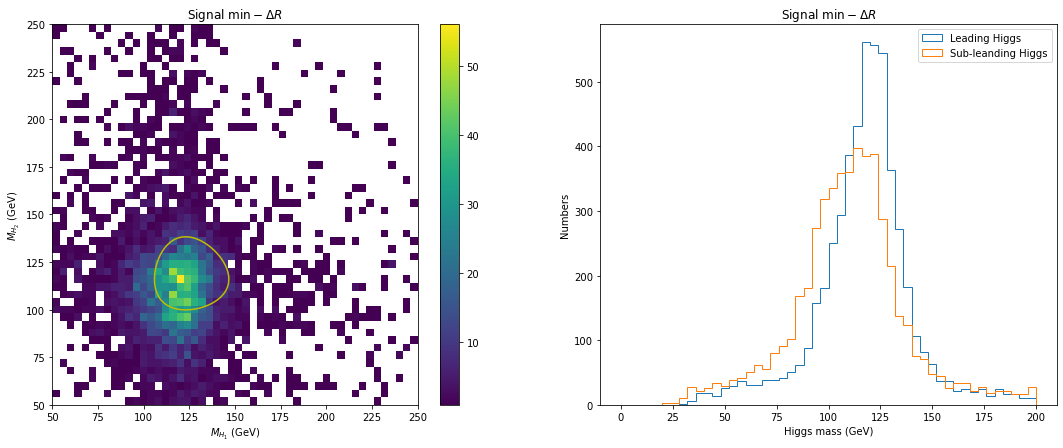

In [33]:
path = 'figures/Higgs_mass_new_min_dR_s.png'
plot_mass_plane(min_s['mh'],m10=124, m20=117, title='Signal $\mathrm{min-}\Delta R$', save_path=path)

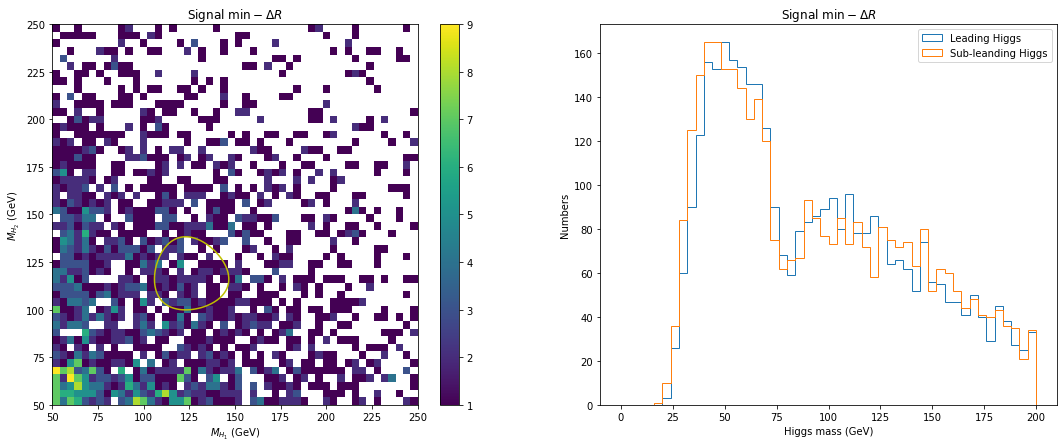

In [34]:
path = 'figures/Higgs_mass_new_min_dR_4b.png'
plot_mass_plane(min_4b['mh'],m10=124, m20=117, title='Signal $\mathrm{min-}\Delta R$', save_path=path)

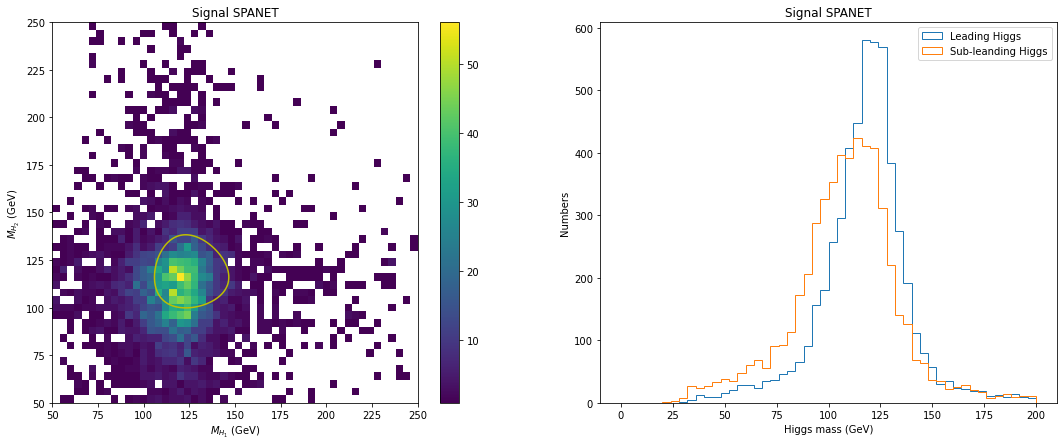

In [35]:
path = 'figures/Higgs_mass_new_SPANET_s.png'
plot_mass_plane(SPANET_s['mh'], m10=124, m20=117, title='Signal SPANET', save_path=path)

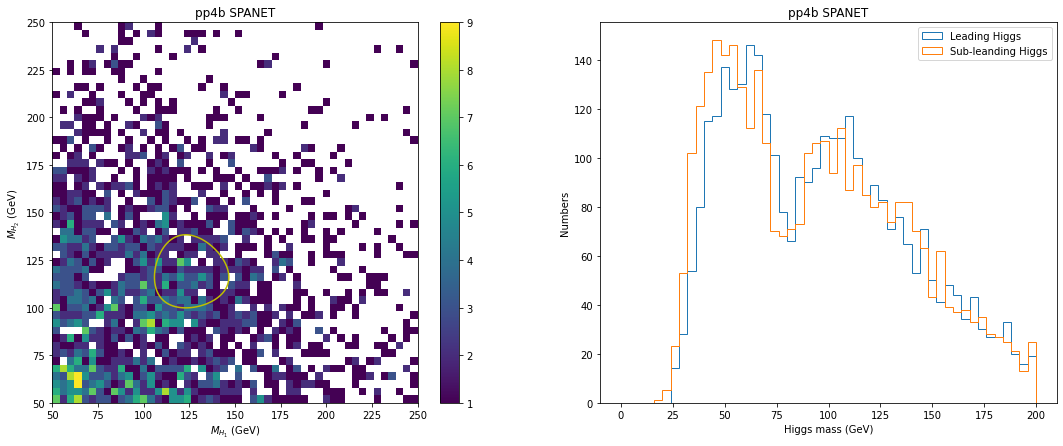

In [36]:
path = 'figures/Higgs_mass_new_SPANET_4b.png'
plot_mass_plane(SPANET_4b['mh'],m10=124, m20=117, title='pp4b SPANET', save_path=path)

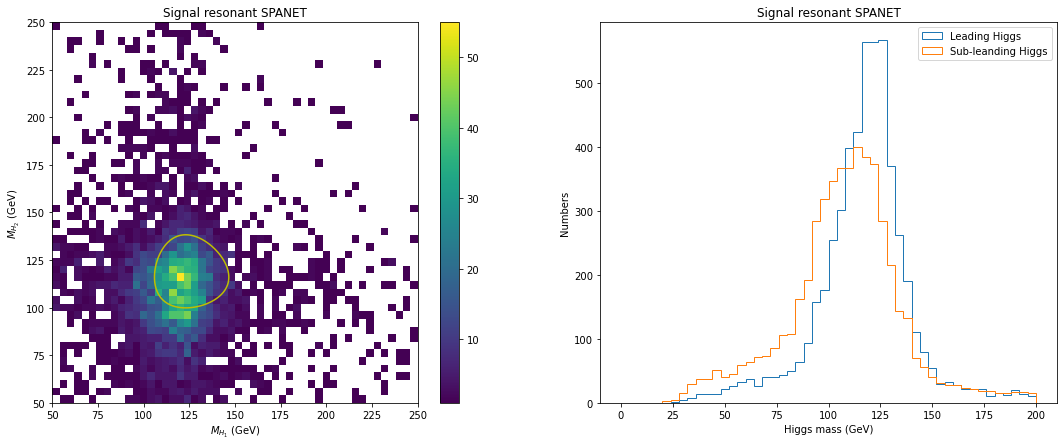

In [37]:
path = 'figures/Higgs_mass_new_res-SPANET_s.png'
plot_mass_plane(res_SPANET_s['mh'], m10=124, m20=117, title='Signal resonant SPANET', save_path = path)

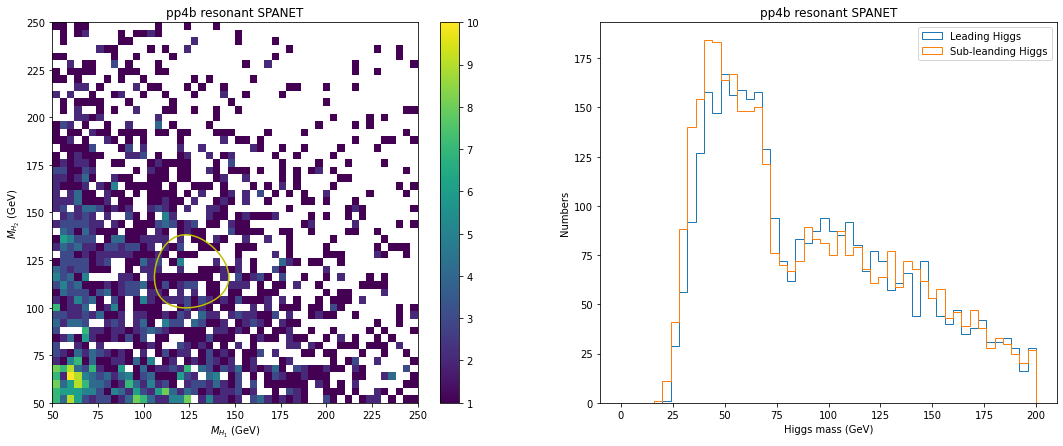

In [38]:
path = 'figures/Higgs_mass_new_res-SPANET_4b.png'
plot_mass_plane(res_SPANET_4b['mh'],m10=124, m20=117, title='pp4b resonant SPANET', save_path=path)

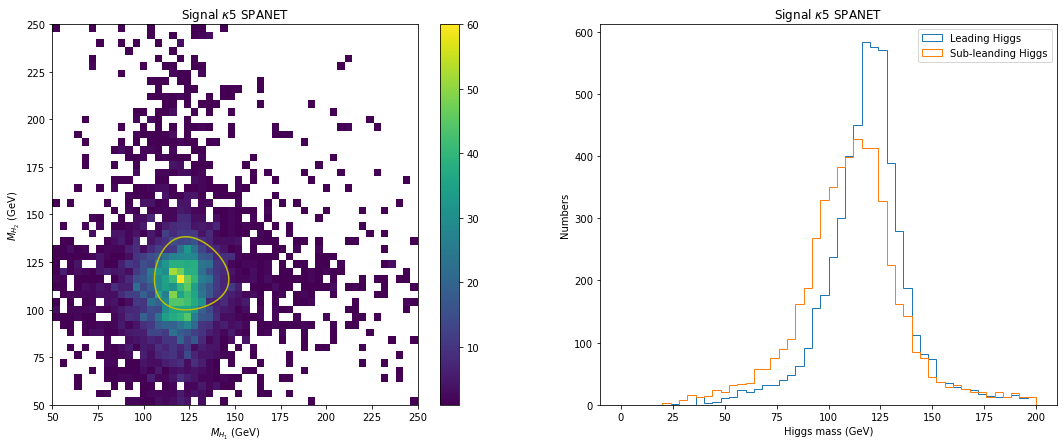

In [39]:
path = 'figures/Higgs_mass_new_k5-SPANET_s.png'
plot_mass_plane(k5_SPANET_s['mh'], m10=124, m20=117, title='Signal $\kappa 5$ SPANET', save_path = path)

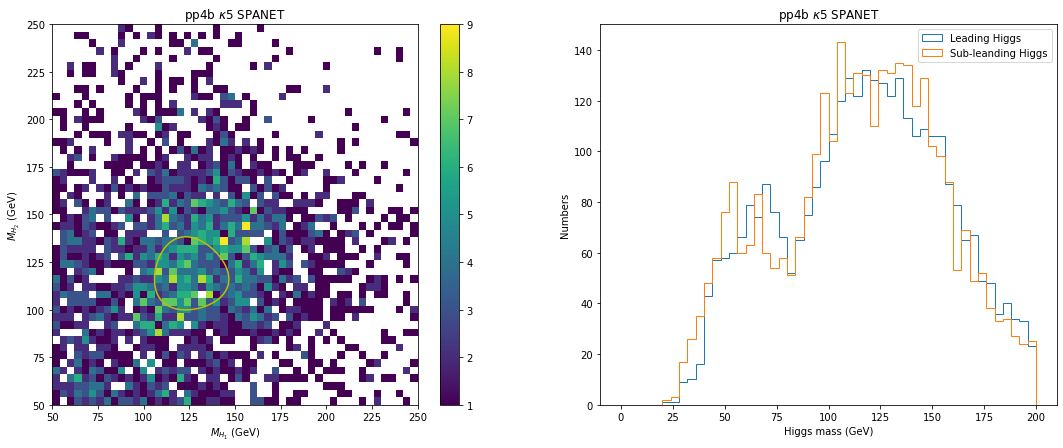

In [40]:
path = 'figures/Higgs_mass_new_k5-SPANET_4b.png'
plot_mass_plane(k5_SPANET_4b['mh'],m10=124, m20=117, title='pp4b $\kappa 5$ SPANET', save_path=path)

## Old

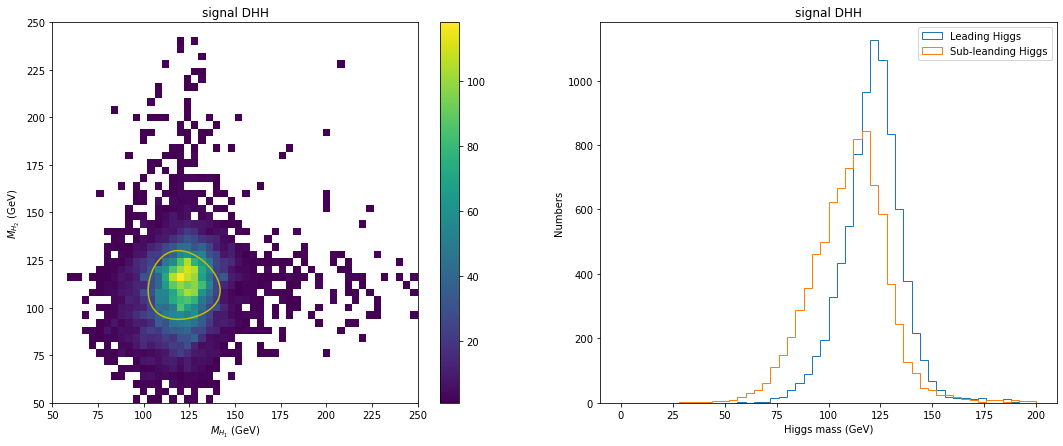

In [41]:
path = 'figures/Higgs_mass_old_DHH_s.png'
plot_mass_plane(old_DHH_s['mh'], m10=120, m20=110, title='signal DHH', save_path=path)

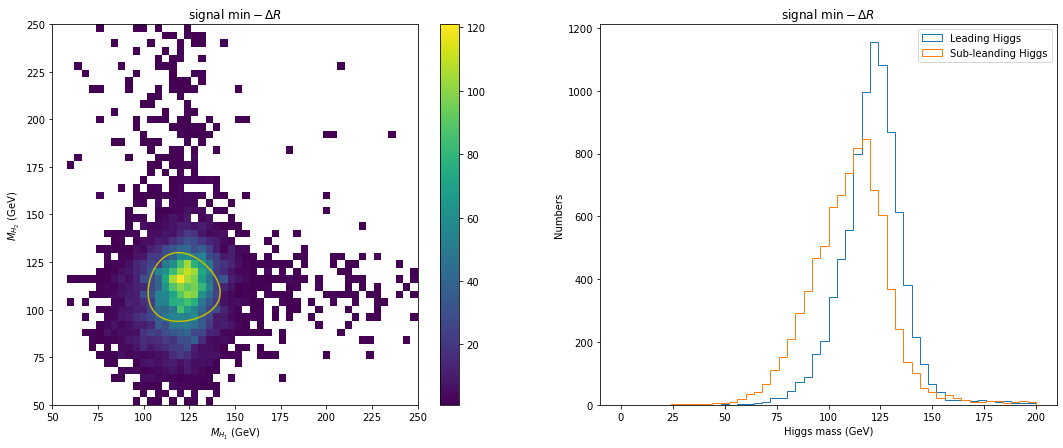

In [42]:
path = 'figures/Higgs_mass_old_mindR_s.png'
plot_mass_plane(old_min_dR_s['mh'], m10=120, m20=110, title='signal $\mathrm{min-}\Delta R$', save_path = path)

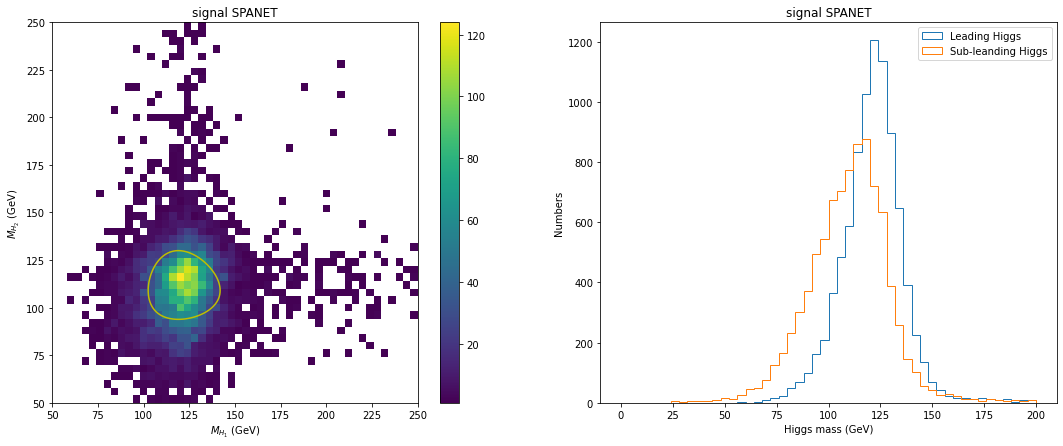

In [43]:
path = 'figures/Higgs_mass_old_SPANET_s.png'
plot_mass_plane(old_SPANET_s['mh'], m10=120, m20=110, title='signal SPANET', save_path=path)

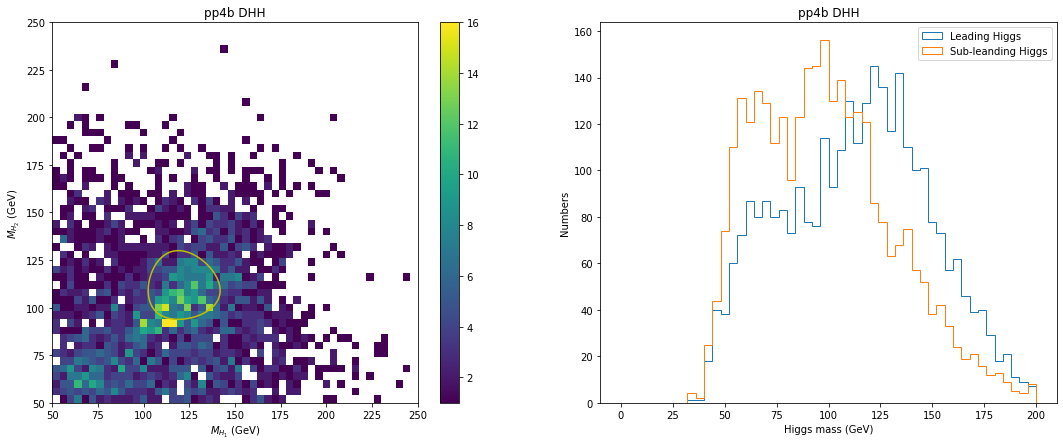

In [44]:
path = 'figures/Higgs_mass_old_DHH_4b.png'
plot_mass_plane(old_DHH_4b['mh'], m10=120, m20=110, title='pp4b DHH', save_path = path)

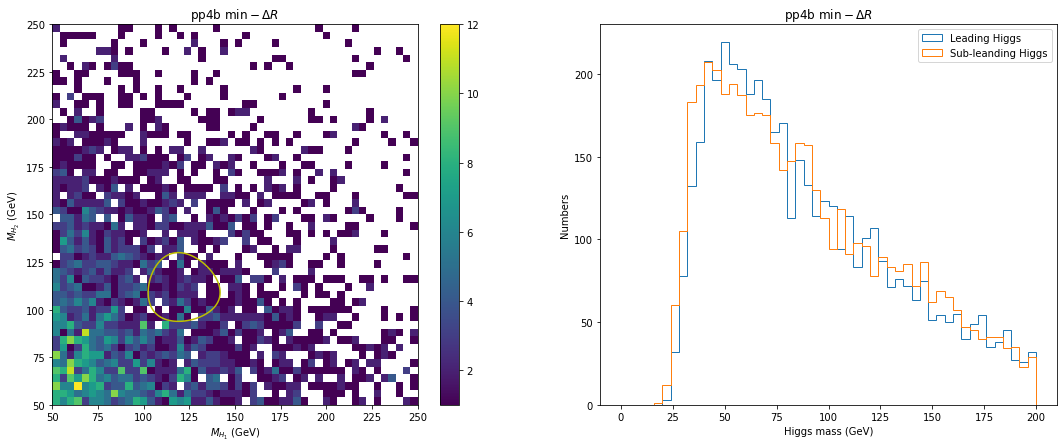

In [45]:
path = 'figures/Higgs_mass_old_mindR_4b.png'
plot_mass_plane(old_min_dR_4b['mh'], m10=120, m20=110, title='pp4b $\mathrm{min-}\Delta R$', save_path = path)

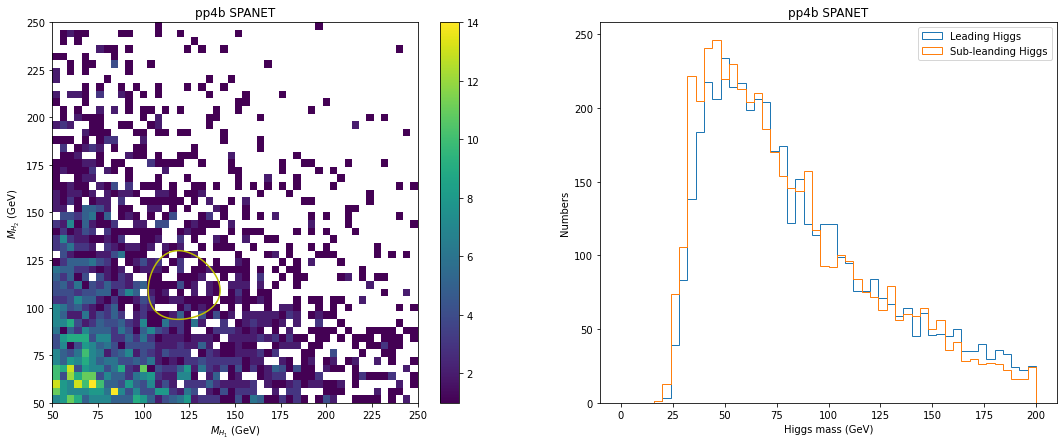

In [46]:
path = 'figures/Higgs_mass_old_SPANET_4b.png'
plot_mass_plane(old_SPANET_4b['mh'], m10=120, m20=110, title='pp4b SPANET', save_path = path)

# Total invariant mass $S / \sqrt{B}$ 

In [47]:
def plot_mHH(mHH, title=''):
    m = mHH

    fig, ax = plt.subplots(1, 1, figsize =(8, 7))

    (n, bins, patches) = ax.hist(m, bins=[200,250,300,350,400,500,1000], range=[200, 1000], histtype='step', label='uncorrected')
    ax.set_xlabel('Di-Higgs mass (GeV)')
    ax.set_ylabel('Numbers')
    ax.set_title(title)
    plt.show()
    
    return n

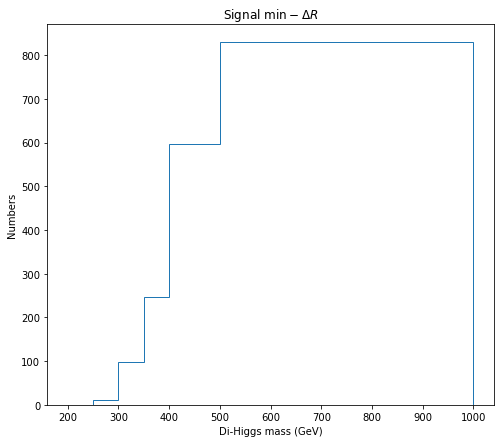

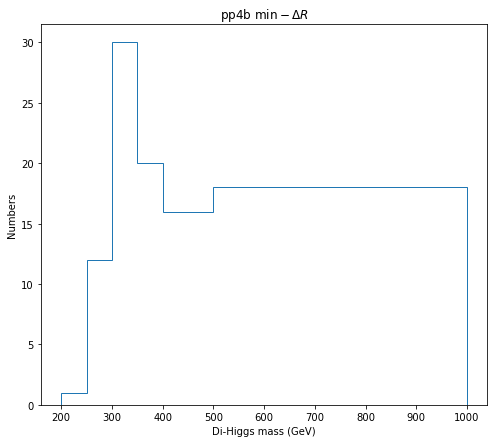

In [48]:
signal = plot_mHH(min_s['mhh'], title='Signal $\mathrm{min-}\Delta R$')
background = plot_mHH(min_4b['mhh'], title='pp4b $\mathrm{min-}\Delta R$')

In [49]:
def print_bin_sb(signal, background, L=139):
#     fig, ax = plt.subplots(1, 1, figsize =(8, 7))
#     (ns, bins, patches) = ax.hist(signal['mhh'], bins=[200,250,300,350,400,500,1000], range=[200, 1000], histtype='step', label='uncorrected')
#     (nb, bins, patches) = ax.hist(background['mhh'], bins=[200,250,300,350,400,500,1000], range=[200, 1000], histtype='step', label='uncorrected')
    ns, bins = np.histogram(signal['mhh'], bins=[200,250,300,350,400,500,1000], range=[200, 1000])
    nb, bins = np.histogram(background['mhh'], bins=[200,250,300,350,400,500,1000], range=[200, 1000])
    
    cross_section_s = signal['cutflow cross section']['Higgs signal']
    cross_section_b = background['cutflow cross section']['Higgs signal']
    n_higgs_signal_s = signal['cutflow count']['Higgs signal']
    n_higgs_signal_b = background['cutflow count']['Higgs signal']

    nS = cross_section_s * ns / n_higgs_signal_s * L
    nB = cross_section_b * nb / n_higgs_signal_s * L
    
    text = 'Lower edge (GeV)'
    for b in bins:
        text += f'{b:9}'
        
    nSB = 'S/B             '
    for n in nS / nB:
        nSB += f'{n:9.3f}'
    nSsqB = 'S/sqrt{B}       '
    for n in nS / nB**0.5:
        nSsqB += f'{n:9.3f}'
        
    print(text)
    print(nSB)
    print(nSsqB)

In [50]:
print('min Delta R')
print_bin_sb(min_s, min_4b)

print('resonant SPA-NET')
print_bin_sb(res_SPANET_s, res_SPANET_4b)

print('k5 SPA-NET')
print_bin_sb(k5_SPANET_s, k5_SPANET_4b)

min Delta R
Lower edge (GeV)      200      250      300      350      400      500     1000
S/B                 0.000    0.002    0.007    0.025    0.076    0.094
S/sqrt{B}           0.000    0.014    0.078    0.244    0.659    0.862
resonant SPA-NET
Lower edge (GeV)      200      250      300      350      400      500     1000
S/B                   nan    0.003    0.012    0.037    0.071    0.124
S/sqrt{B}             nan    0.012    0.102    0.313    0.654    0.965
k5 SPA-NET
Lower edge (GeV)      200      250      300      350      400      500     1000
S/B                 0.000    0.000    0.001    0.008    0.024    0.031
S/sqrt{B}           0.000    0.008    0.043    0.145    0.374    0.503


/tmp/ipykernel_4163656/2367158037.py:21: RuntimeWarning: invalid value encountered in true_divide
  for n in nS / nB:
/tmp/ipykernel_4163656/2367158037.py:24: RuntimeWarning: invalid value encountered in true_divide
  for n in nS / nB**0.5:
